In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import re
from PIL import Image
import json
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.preprocessing.text import tokenizer_from_json

from nltk.translate.bleu_score import corpus_bleu

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
FLICKER_BASE_DIR = './flickrdata'
NEWS_BASE_DIR = './newsdata'
NEWS_WORK_DIR = './newsmodels'
WORKING_DIR = './finetuning'

In [4]:
with open(os.path.join(NEWS_WORK_DIR, 'newsfeaturesextracted.pkl'), 'rb') as f:
    news_features = pickle.load(f)

In [5]:
with open(os.path.join(NEWS_BASE_DIR, 'news_captions_ner.txt'), 'r') as f:
    next(f)
    news_captions_doc = f.read()

## Extract flickr image features from VGG16

In [5]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
flicker_features = {}
directory = os.path.join(FLICKER_BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # # extract features
    feature = model.predict(image,verbose=0)
    # # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    flicker_features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [8]:
pickle.dump(flicker_features, open(os.path.join(WORKING_DIR, 'flickrfeaturesextracted.pkl'), 'wb'))

In [6]:
with open(os.path.join(WORKING_DIR, 'flickrfeaturesextracted.pkl'), 'rb') as f:
    flicker_features = pickle.load(f)

In [7]:
with open(os.path.join(FLICKER_BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    flicker_captions_doc = f.read()

In [8]:
captions_doc = flicker_captions_doc + news_captions_doc

In [9]:
len(flicker_features)

8091

In [10]:
len(news_features)

8000

In [11]:
features = {**flicker_features, **news_features}

## Preprocess and tokenize image captions

In [12]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/48456 [00:00<?, ?it/s]

In [13]:
len(mapping)

16091

In [14]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = re.sub('[^<>_A-Za-z]', ' ',caption)
            # delete additional spaces
            caption = re.sub('\s+', ' ',caption)
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [15]:
mapping['4fd2a7ca8eb7c8105d8913b6_0']

['<PERSON> stars as a cando widow who moves to <GPE> in The Best Exotic Marigold Hotel']

In [16]:
clean(mapping)

In [17]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [18]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [19]:
len(all_captions)

48455

In [20]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [25]:
tokenizer = Tokenizer(filters = '!"#$%&()*+,./:;=?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [36]:
vocab_size

18096

In [21]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

107

In [38]:
tokenizer_json = tokenizer.to_json()
with open(WORKING_DIR+'/tokenizer.json', 'w') as fp:
    json.dump(tokenizer_json, fp)

## Train base image captioner on flickr images

In [22]:
image_ids = list(flicker_features.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [23]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [26]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [42]:
epochs = 10
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 114s 502ms/step - loss: 2.6227


In [43]:
model.save(WORKING_DIR+'/finetuningbase.h5')

## Generate captions with the base model

In [27]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [28]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [29]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_flicker_caption(image_name,model,features,tokenizer,max_length):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(FLICKER_BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    display(image)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    
def generate_news_caption(image_name,model,features,tokenizer,max_length):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(NEWS_BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    display(image)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)

In [47]:
test[:10]

['436015762_8d0bae90c3',
 '436393371_822ee70952',
 '436608339_f1d1298770',
 '437054333_5c2761b8cd',
 '437404867_209625774d',
 '437527058_189f2a7eef',
 '437917001_ae1106f34e',
 '438639005_208bc59b0b',
 '439037721_cdf1fc7358',
 '439049388_3dcee2d30b']

In [48]:
model_base = load_model(WORKING_DIR+'/finetuningbase.h5')
with open(WORKING_DIR+'/tokenizer.json') as f:
    tokenizer_data = json.load(f)
    loaded_tokenizer = tokenizer_from_json(tokenizer_data)

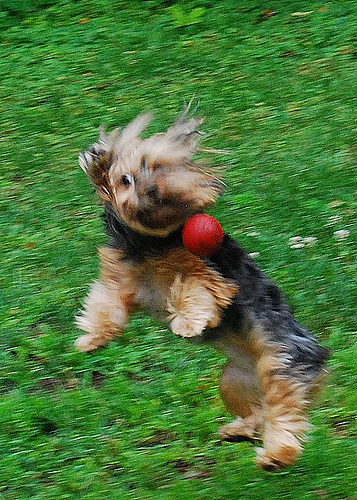

---------------------Actual---------------------
startseq dog jumps to catch red ball outside endseq
startseq small shaggy dog plays with red ball on the grass endseq
startseq yorkie trying to catch red toy endseq
startseq little dog is jumping up to catch red ball in its mouth endseq
startseq the dog jumps up to catch the red ball endseq
--------------------Predicted--------------------
startseq small dog in the green dress is playing with toy in the grass endseq


In [50]:
generate_flicker_caption("661749711_6f408dad62.jpg",model_base,features,loaded_tokenizer,107)

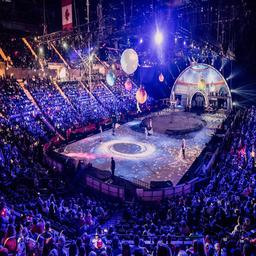

---------------------Actual---------------------
startseq the circuss operator decided to close it after prolonged slump in ticket sales but many in attendance on <date> said they believed the circus would somehow return perhaps retooled and rebranded endseq
--------------------Predicted--------------------
startseq man in pink and white suit is standing in front of crowd endseq


In [52]:
generate_news_caption("5922396295d0e024b5872194_4.jpg",model_base,features,loaded_tokenizer,107)

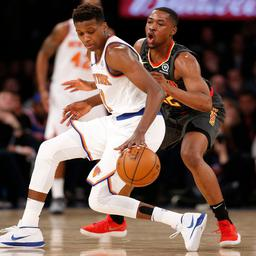

---------------------Actual---------------------
startseq ntilikina being guarded by <person> of <org> when the <org> selected <person> and <org> employees celebrated in the <gpe> draft room endseq
--------------------Predicted--------------------
startseq two basketball players in basketball game endseq


In [53]:
generate_news_caption("5a4fdeb795d0e0110c1a31c1_4.jpg",model_base,features,loaded_tokenizer,107)

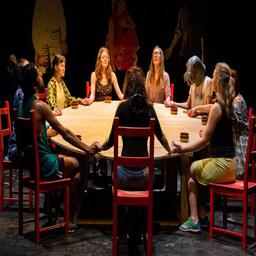

---------------------Actual---------------------
startseq <org> left <person> <person> and <person> with other cast members at <org> endseq
--------------------Predicted--------------------
startseq man in pink shirt is sitting on stool at the sound bar endseq


In [56]:
generate_news_caption("5568fc4338f0d87c79ae603e_1.jpg",model_base,features,loaded_tokenizer,107)

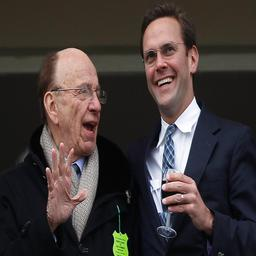

---------------------Actual---------------------
startseq as <person> nears <cardinal> many see his son <person> as the heir apparent endseq
--------------------Predicted--------------------
startseq man in tuxedo and white shirt and tie and tie and woman in black and white shirt and black hair and white hair and white hair and white hair and white hair and black and white are standing in front of the other man endseq


In [54]:
generate_news_caption("540af3be38f0d84fb8834395_0.jpg",model_base,features,loaded_tokenizer,107)

## Evaluate base model on test flickr images

In [58]:
def evaluate(test_data, model, features, tokenizer, max_length):
    # validate with test data
    actual, predicted = list(), list()

    for key in tqdm(test_data):
        # get actual caption
        captions = mapping[key]
        # predict the caption for image
        y_pred = predict_caption(model, features[key], tokenizer, max_length) 
        # split into words
        actual_captions = [caption.split() for caption in captions]
        y_pred = y_pred.split()
        # append to the list
        actual.append(actual_captions)
        predicted.append(y_pred)
        
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

In [59]:
evaluate(test, model_base, features, loaded_tokenizer, 107)

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.524007
BLEU-2: 0.303727


BLEU-1: 0.524007
BLEU-2: 0.303727

## Fine-tune trained model on news images

In [33]:
news_train = list(np.loadtxt(NEWS_WORK_DIR+'/news_train_id.txt',dtype=str))
news_test = list(np.loadtxt(NEWS_WORK_DIR+'/news_test_id.txt',dtype=str))

In [82]:
# epochs = 5
epochs = 15
batch_size = 32
steps = len(news_train) // batch_size
model = load_model(WORKING_DIR+'/finetuningbase.h5')

for i in range(epochs):
    # create data generator
    generator = data_generator(news_train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

225/225 [==============================] - 99s 440ms/step - loss: 3.0748


In [83]:
# model.save(WORKING_DIR+'/finetuningfive.h5')
model.save(WORKING_DIR+'/finetuningfifteen.h5')

## Generate captions with fine-tuned models

In [84]:
model_5 = load_model(WORKING_DIR+'/finetuningfive.h5')
model_15 = load_model(WORKING_DIR+'/finetuningfifteen.h5')

In [93]:
news_test[:10]

['5922396295d0e024b5872194_4',
 '51c1d7c27e0d9c0839d29b3e_2',
 '570673aa38f0d86865ca551e_1',
 '5911d8d795d0e024b586fbf8_2',
 '5ae39b9c068401528a2ab2af_1',
 '5824b53695d0e0204d55fc12_0',
 '560db6e938f0d81aa77a51cb_0',
 '59e869e795d0e0246f210e74_14',
 '5602cf2638f0d84a40af501e_0',
 '515da18ecf28d0219d001110_1']

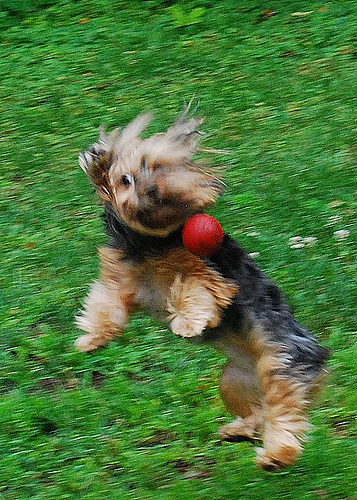

---------------------Actual---------------------
startseq dog jumps to catch red ball outside endseq
startseq small shaggy dog plays with red ball on the grass endseq
startseq yorkie trying to catch red toy endseq
startseq little dog is jumping up to catch red ball in its mouth endseq
startseq the dog jumps up to catch the red ball endseq
--------------------Predicted--------------------
startseq the new new new new new <ordinal> of the <ordinal> of the <ordinal> of the <ordinal> of the other other other <person> endseq


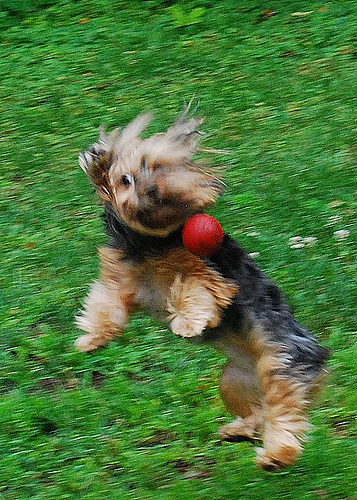

---------------------Actual---------------------
startseq dog jumps to catch red ball outside endseq
startseq small shaggy dog plays with red ball on the grass endseq
startseq yorkie trying to catch red toy endseq
startseq little dog is jumping up to catch red ball in its mouth endseq
startseq the dog jumps up to catch the red ball endseq
--------------------Predicted--------------------
startseq ms digest satin rhinestone floor with rhinestone ring handles <date> endseq


In [87]:
generate_flicker_caption("661749711_6f408dad62.jpg",model_5,features,loaded_tokenizer,107)
generate_flicker_caption("661749711_6f408dad62.jpg",model_15,features,loaded_tokenizer,107)

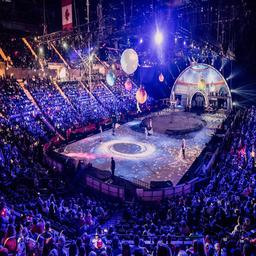

---------------------Actual---------------------
startseq the circuss operator decided to close it after prolonged slump in ticket sales but many in attendance on <date> said they believed the circus would somehow return perhaps retooled and rebranded endseq
--------------------Predicted--------------------
startseq the <org> in <gpe> in <date> endseq


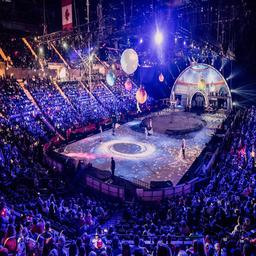

---------------------Actual---------------------
startseq the circuss operator decided to close it after prolonged slump in ticket sales but many in attendance on <date> said they believed the circus would somehow return perhaps retooled and rebranded endseq
--------------------Predicted--------------------
startseq <person> and <person> in <gpe> endseq


In [88]:
generate_news_caption("5922396295d0e024b5872194_4.jpg",model_5,features,loaded_tokenizer,107)
generate_news_caption("5922396295d0e024b5872194_4.jpg",model_15,features,loaded_tokenizer,107)

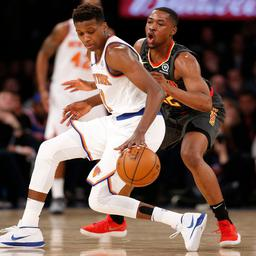

---------------------Actual---------------------
startseq ntilikina being guarded by <person> of <org> when the <org> selected <person> and <org> employees celebrated in the <gpe> draft room endseq
--------------------Predicted--------------------
startseq <person> and <person> in <date> endseq


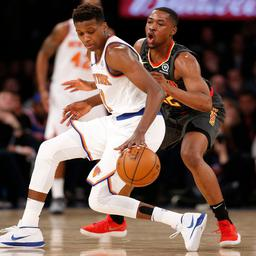

---------------------Actual---------------------
startseq ntilikina being guarded by <person> of <org> when the <org> selected <person> and <org> employees celebrated in the <gpe> draft room endseq
--------------------Predicted--------------------
startseq <person> sprint hopeful endseq


In [89]:
generate_news_caption("5a4fdeb795d0e0110c1a31c1_4.jpg",model_5,features,loaded_tokenizer,107)
generate_news_caption("5a4fdeb795d0e0110c1a31c1_4.jpg",model_15,features,loaded_tokenizer,107)

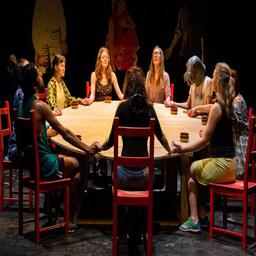

---------------------Actual---------------------
startseq <org> left <person> <person> and <person> with other cast members at <org> endseq
--------------------Predicted--------------------
startseq <person> and <person> in the <gpe> <gpe> endseq


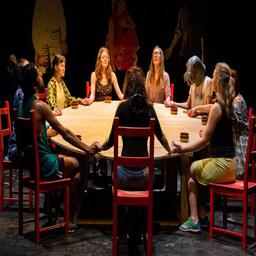

---------------------Actual---------------------
startseq <org> left <person> <person> and <person> with other cast members at <org> endseq
--------------------Predicted--------------------
startseq <person> and <person> in <gpe> endseq


In [90]:
generate_news_caption("5568fc4338f0d87c79ae603e_1.jpg",model_5,features,loaded_tokenizer,107)
generate_news_caption("5568fc4338f0d87c79ae603e_1.jpg",model_15,features,loaded_tokenizer,107)

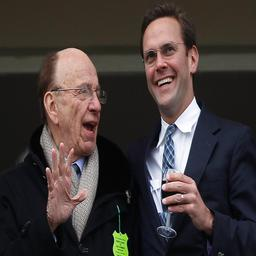

---------------------Actual---------------------
startseq as <person> nears <cardinal> many see his son <person> as the heir apparent endseq
--------------------Predicted--------------------
startseq <person> and <person> in <date> endseq


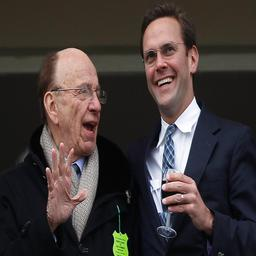

---------------------Actual---------------------
startseq as <person> nears <cardinal> many see his son <person> as the heir apparent endseq
--------------------Predicted--------------------
startseq <person> and <person> in <date> endseq


In [92]:
generate_news_caption("540af3be38f0d84fb8834395_0.jpg",model_5,features,loaded_tokenizer,107)
generate_news_caption("540af3be38f0d84fb8834395_0.jpg",model_15,features,loaded_tokenizer,107)

## Evaluate fine-tuned models on test news images

In [94]:
evaluate(news_test, model_5, features, loaded_tokenizer, 107)

  0%|          | 0/800 [00:00<?, ?it/s]

BLEU-1: 0.173392
BLEU-2: 0.085900


BLEU-1: 0.173392
BLEU-2: 0.085900

In [95]:
evaluate(news_test, model_15, features, loaded_tokenizer, 107)

  0%|          | 0/800 [00:00<?, ?it/s]

BLEU-1: 0.203556
BLEU-2: 0.097811


BLEU-1: 0.203556
BLEU-2: 0.097811

## Re-train models without distinguishing named entities and normal words (e.g. person and <person> will be the same token)

In [30]:
tokenizer_mix = Tokenizer()
tokenizer_mix.fit_on_texts(all_captions)
vocab_size_mix = len(tokenizer_mix.word_index) + 1

In [31]:
vocab_size_mix

18085

In [37]:
with open(WORKING_DIR+'/tokenizer_mix.json', 'w') as fp:
    json.dump(tokenizer_mix.to_json(), fp)

In [42]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size_mix, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size_mix, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [43]:
epochs = 10
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer_mix, max_length, vocab_size_mix, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 108s 475ms/step - loss: 2.6236


In [44]:
model.save(WORKING_DIR+'/finetuningbase_mix.h5')

In [49]:
# epochs = 5
epochs = 15
batch_size = 32
steps = len(news_train) // batch_size
model = load_model(WORKING_DIR+'/finetuningbase_mix.h5')

for i in range(epochs):
    # create data generator
    generator = data_generator(news_train, mapping, features, tokenizer_mix, max_length, vocab_size_mix, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

225/225 [==============================] - 98s 435ms/step - loss: 2.9249


In [50]:
# model.save(WORKING_DIR+'/finetuningfive_mix.h5')
model.save(WORKING_DIR+'/finetuningfifteen_mix.h5')

In [61]:
def evaluate_mix(test_data, model, features, tokenizer, max_length):
    # validate with test data
    actual, predicted = list(), list()

    for key in tqdm(test_data):
        # get actual caption
        captions = mapping[key]
        # predict the caption for image
        y_pred = predict_caption(model, features[key], tokenizer, max_length) 
        # split into words
        actual_captions = [re.sub('[^A-Za-z]', ' ',caption).split() for caption in captions]
        y_pred = y_pred.split()
        # append to the list
        actual.append(actual_captions)
        predicted.append(y_pred)
        
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

In [62]:
model_5_mix = load_model(WORKING_DIR+'/finetuningfive_mix.h5')
model_15_mix = load_model(WORKING_DIR+'/finetuningfifteen_mix.h5')

In [63]:
evaluate_mix(news_test, model_5_mix, features, tokenizer_mix, 107)

  0%|          | 0/800 [00:00<?, ?it/s]

BLEU-1: 0.150249
BLEU-2: 0.076179


BLEU-1: 0.150249
BLEU-2: 0.076179

In [64]:
evaluate_mix(news_test, model_15_mix, features, tokenizer_mix, 107)

  0%|          | 0/800 [00:00<?, ?it/s]

BLEU-1: 0.243895
BLEU-2: 0.114239


BLEU-1: 0.243895
BLEU-2: 0.114239